# Ohio Timeseries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
#import pmdarima as pm

### Loading data

In [3]:
df_emp=pd.read_pickle("emp_dfpkl.sec")

In [4]:
df_emp= df_emp[['Michigan','California','Ohio','Texas','Indiana']]

In [5]:
emp_final= df_emp[238:]

#### Indiana Dataset

In [6]:
ohio=emp_final['Ohio']

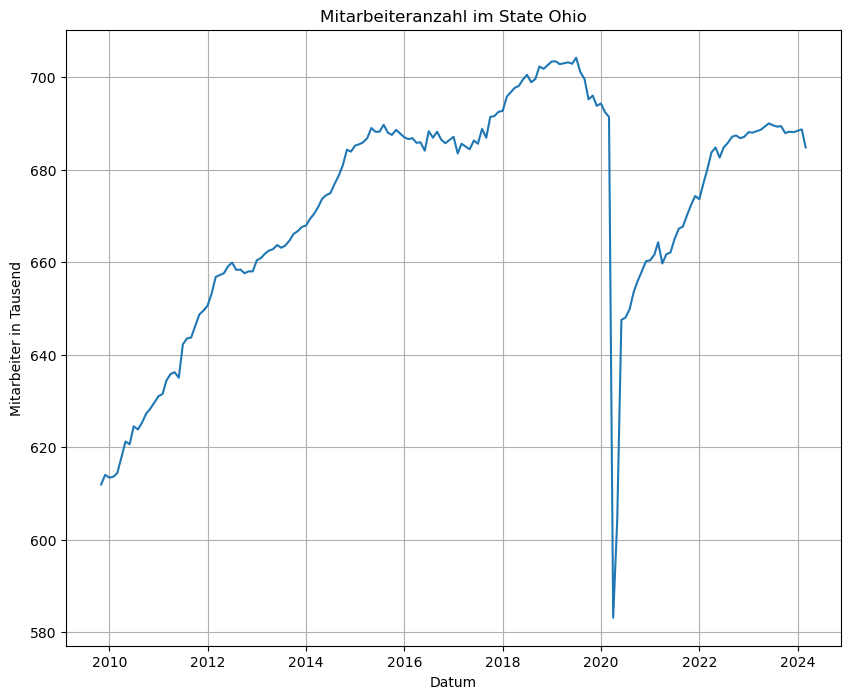

In [7]:
plt.figure(figsize=(10, 8))
plt.plot(ohio)
plt.title('Mitarbeiteranzahl im State Ohio')
plt.xlabel('Datum')
plt.ylabel('Mitarbeiter in Tausend')
plt.grid(True)
plt.show()

### Test und Trainingsdaten

In [8]:
#Test und Traingsdaten
train = ohio[:int(0.9 * len(ohio))]
test = ohio[int(0.9 * len(ohio)):]

In [9]:
pred_start= test.index[0]
pred_end= test.index[-1]

In [10]:
print(f"Länge des Trainingsdatensatzes: {len(train)}")
print(f"Länge des Testdatensatzes: {len(test)}")

Länge des Trainingsdatensatzes: 155
Länge des Testdatensatzes: 18


# Samira

### Besteht aus ARIMA (AR -> Autoregression, I -> Differenzierung und MA-> Gleitender Durschschnitt) plus Saisonale Komponenten S auf ARIMA 

## 1. Stationary

In [11]:
result = adfuller(ohio)
print(f'ADF Test Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Test Statistic: -2.6207507005083905
p-value: 0.0887839096332872


keine stationarity

In [12]:
ohio_diff= ohio.diff().dropna()

In [13]:
result = adfuller(ohio_diff)
print(f'ADF Test Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Test Statistic: -12.965272234406381
p-value: 3.1631194122833257e-24


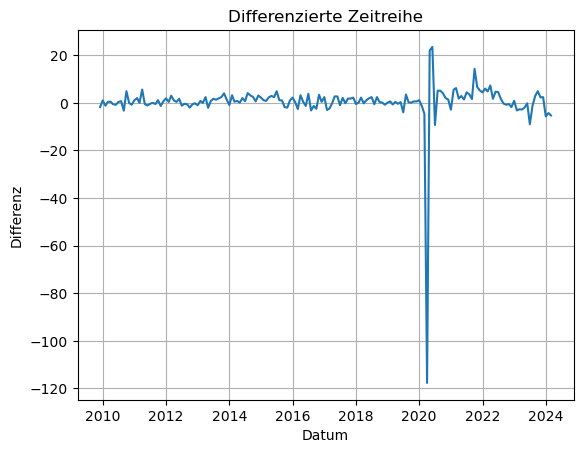

In [21]:
plt.plot(california_diff)
plt.title('Differenzierte Zeitreihe')
plt.xlabel('Datum')
plt.ylabel('Differenz')
plt.grid(True)
plt.show()

## 2. PACF und ACF

In [14]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

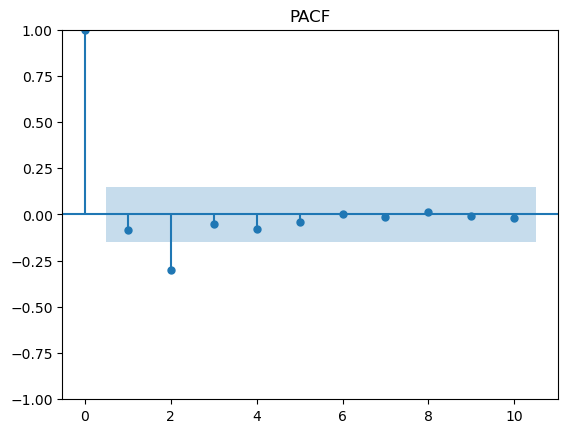

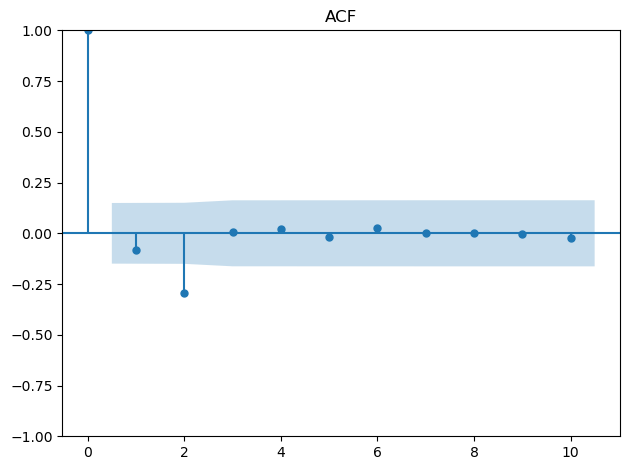

In [15]:
plot_pacf(ohio_diff,lags=10,title='PACF')
plot_acf(ohio_diff,lags=10,title='ACF')
plt.tight_layout()
plt.show()

### Gleitender Durchschnitt mit rolling window

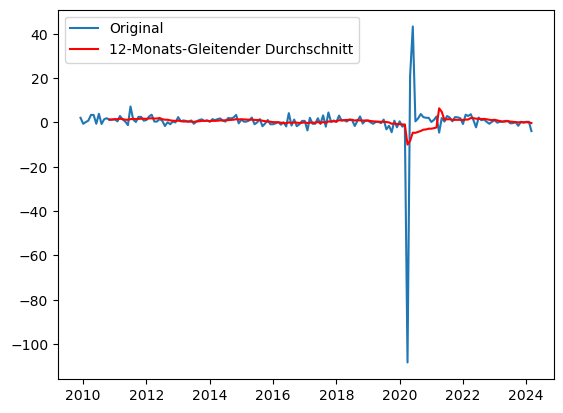

In [16]:
MA = ohio_diff.rolling(window=12).mean()
plt.plot(ohio_diff, label='Original')
plt.plot(MA, label='12-Monats-Gleitender Durchschnitt', color='red')
plt.legend()
plt.show()

### Gleitender durschnitt mit ARIMA

In [17]:
from statsmodels.tsa.arima.model import ARIMA

In [18]:
#MA_modell= ARIMA(train,order=(0,0,2)) # -> nur MA berechnung
MA_modell= ARIMA(train,order=(0,0,2)) # -> nur MA berechnung

C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [19]:
MA_fit= MA_modell.fit()
print(MA_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                   Ohio   No. Observations:                  155
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -618.991
Date:                Sat, 05 Oct 2024   AIC                           1245.983
Time:                        23:53:21   BIC                           1258.156
Sample:                    11-01-2009   HQIC                          1250.927
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        669.5610      3.724    179.773      0.000     662.261     676.861
ma.L1          1.1112      0.040     27.644      0.000       1.032       1.190
ma.L2          0.5139      0.047     10.966      0.0

P > Z sagt aus welche Lags signifikant sind. alles unter 0.05 sind nicht signifikant

In [20]:
ma_pred=MA_fit.predict(start=pred_start, end= pred_end)
residuals=test-ma_pred

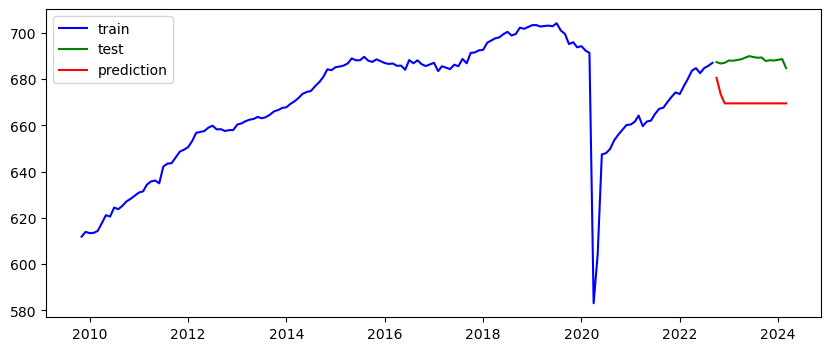

In [21]:
plt.figure(figsize=(10,4))
plt.plot(train, label='train',color= 'blue')
plt.plot(test, label='test',color='green')
plt.plot( ma_pred, label='prediction',color='red')
plt.legend()
plt.show()

# AR -> Autoregression 

In [22]:
ar_modell= ARIMA(train,order=(2,0,0))
ar_fit=ar_modell.fit()
print(ar_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   Ohio   No. Observations:                  155
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -571.256
Date:                Sat, 05 Oct 2024   AIC                           1150.513
Time:                        23:53:32   BIC                           1162.686
Sample:                    11-01-2009   HQIC                          1155.457
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        666.2561     28.608     23.289      0.000     610.185     722.327
ar.L1          0.8937      0.089     10.006      0.000       0.719       1.069
ar.L2          0.0459      0.063      0.730      0.4

C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Prediction with Ar models

In [23]:
ar_pred=ar_fit.predict(start=pred_start, end= pred_end)
residuals=test-ar_pred

Ploting

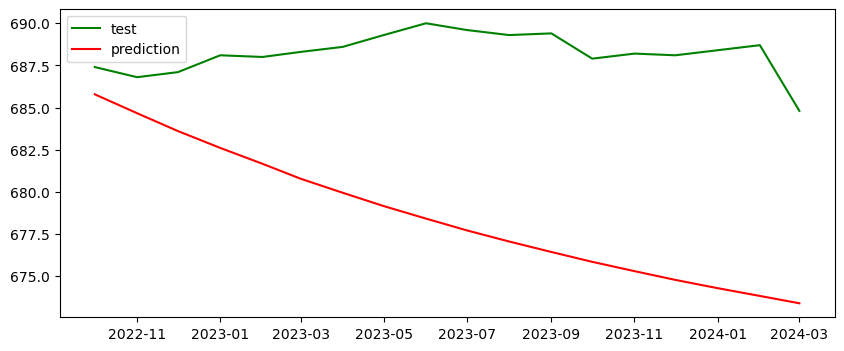

In [24]:
plt.figure(figsize=(10,4))
#plt.plot(train, label='train',color= 'blue')
plt.plot(test, label='test',color='green')
plt.plot( ar_pred, label='prediction',color='red')
plt.legend()
plt.show()

### Evaulation

In [25]:
test_mae = mean_absolute_error(test, ar_pred)
test_mse = mean_squared_error(test, ar_pred)
test_rmse = mean_squared_error(test, ar_pred, squared=False)
test_r2 = r2_score(test, ar_pred)

In [26]:
print('mae',test_mae)
print('mse',test_mse)
print('rmse',test_rmse)
print('r2',test_r2)

mae 9.605983624096053
mse 108.93925533083276
rmse 10.437396961447465
r2 -77.33877558413843


# Arima (p,d,q)

In [27]:
arima_modell= ARIMA(train, order=(2,1,2)) #best order 3,0,1
arima_fit=arima_modell.fit()
print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   Ohio   No. Observations:                  155
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -560.696
Date:                Sat, 05 Oct 2024   AIC                           1131.391
Time:                        23:53:35   BIC                           1146.576
Sample:                    11-01-2009   HQIC                          1137.559
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0123      0.506      0.024      0.981      -0.979       1.004
ar.L2         -0.1114      0.265     -0.420      0.674      -0.631       0.408
ma.L1         -0.1360      0.503     -0.270      0.7

C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [28]:
arima_pred=arima_fit.predict(start=pred_start, end= pred_end)
residuals=test-arima_pred

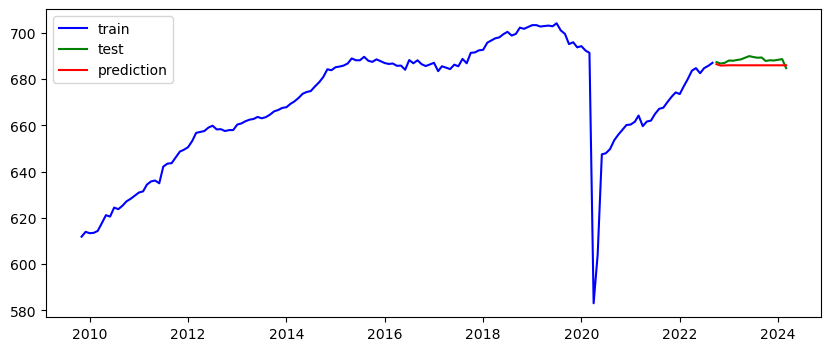

In [29]:
plt.figure(figsize=(10,4))
plt.plot(train, label='train',color= 'blue')
plt.plot(test, label='test',color='green')
plt.plot( arima_pred, label='prediction',color='red')
plt.legend()
plt.show()

# Evaulation

In [30]:
test_mae = mean_absolute_error(test, arima_pred)
test_mse = mean_squared_error(test, arima_pred)
test_rmse = mean_squared_error(test, arima_pred, squared=False)
test_r2 = r2_score(test, arima_pred)

In [31]:
print('mae',test_mae)
print('mse',test_mse)
print('rmse',test_rmse)
print('r2',test_r2)

mae 2.3123658135072054
mse 6.1565659685375635
rmse 2.481242827402744
r2 -3.4272180704149227


# Sarima (p,d,q)(P,D,Q)s

In [32]:
my_order = (2,1,2)
my_sorder = (1,1,1,12)

In [33]:
sarima_modell = SARIMAX(train, order=my_order, seasonal_order=my_sorder)
sarima_fit=sarima_modell.fit()
print(sarima_fit.summary())

C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                                 Ohio   No. Observations:                  155
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 12)   Log Likelihood                -531.984
Date:                              Sat, 05 Oct 2024   AIC                           1077.969
Time:                                      23:53:38   BIC                           1098.660
Sample:                                  11-01-2009   HQIC                          1086.377
                                       - 09-01-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0073      0.733     -0.010      0.992      -1.444       1.430
ar.L2         -0.10

In [34]:
sarima_pred=sarima_fit.predict(start=pred_start, end= pred_end)
residuals=test-sarima_pred

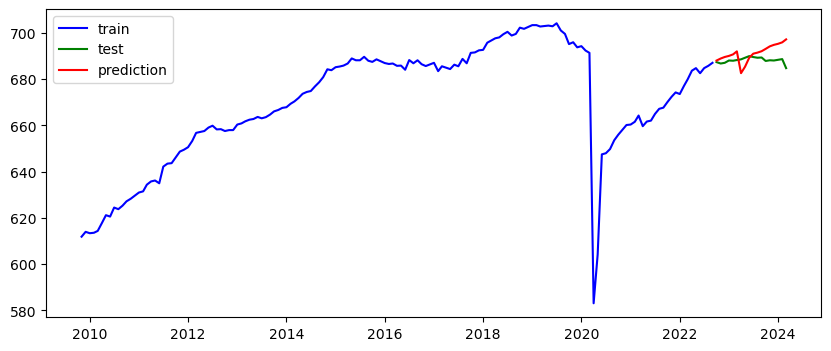

In [35]:
plt.figure(figsize=(10,4))
plt.plot(train, label='train',color= 'blue')
plt.plot(test, label='test',color='green')
plt.plot( sarima_pred, label='prediction',color='red')
plt.legend()
plt.show()

# Evaulation

In [36]:
test_mae = mean_absolute_error(test, sarima_pred)
test_mse = mean_squared_error(test, sarima_pred)
test_rmse = mean_squared_error(test, sarima_pred, squared=False)
test_r2 = r2_score(test, sarima_pred)

In [37]:
print('mae',test_mae)
print('mse',test_mse)
print('MSE', round(np.mean(abs(residuals/test)),4))
print('rmse',test_rmse)
print('r2',test_r2)

mae 4.1883011480839265
mse 25.952399649578677
MSE 0.0061
rmse 5.094349776917431
r2 -17.662503299146383


# Auto Sarima

In [38]:
import pmdarima as pm

In [39]:
auto_sarima = pm.auto_arima(train,d=None, stationary= False,
                           m=12, start_p=0, max_p=11, max_d= 1,approximation = True, start_q=0, max_q=11, start_P=0, D=None, start_Q=0, max_P=11, max_D=1, max_Q=11, trace=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1141.352, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1144.098, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1142.540, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1139.741, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1143.139, Time=0.06 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1143.123, Time=0.05 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1144.934, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1142.306, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1140.763, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1135.124, Time=0.05 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=1136.937, Time=0.11 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=1136.914, Time=0.12 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=1138.546, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=1130.920, Time=0.07 sec
 ARIMA(2,1,1)(1,0,0

In [40]:
my_order = (0,1,0)
my_sorder = (0,0,0,12)

In [41]:
a_sarima = SARIMAX(train, order=my_order, seasonal_order=my_sorder)
auto_s_fit = a_sarima.fit()
print(auto_s_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   Ohio   No. Observations:                  155
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -568.870
Date:                Sat, 05 Oct 2024   AIC                           1139.741
Time:                        23:53:43   BIC                           1142.778
Sample:                    11-01-2009   HQIC                          1140.974
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        94.6370      1.514     62.493      0.000      91.669      97.605
Ljung-Box (L1) (Q):                   1.07   Jarque-Bera (JB):             68152.44
Prob(Q):                              0.30   Pr

C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [42]:
auto_sarima_pred=auto_s_fit.predict(start=pred_start, end= pred_end)
residuals=test-auto_sarima_pred

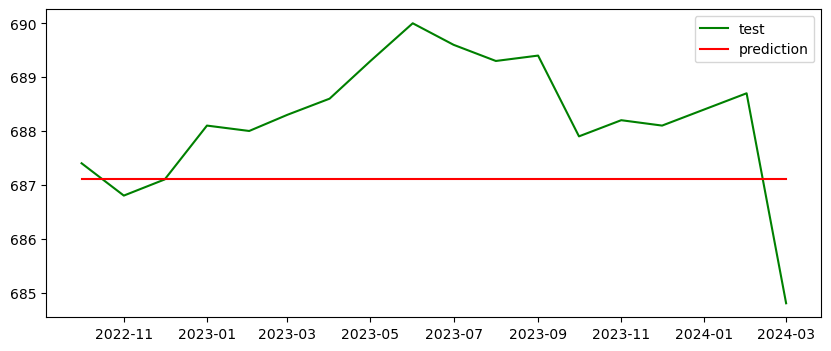

In [43]:
plt.figure(figsize=(10,4))
#plt.plot(train, label='train',color= 'blue')
plt.plot(test, label='test',color='green')
plt.plot( auto_sarima_pred, label='prediction',color='red')
plt.legend()
plt.show()

# Evaulation

In [44]:
test_mae = mean_absolute_error(test, auto_sarima_pred)
test_mse = mean_squared_error(test, auto_sarima_pred)
test_rmse = mean_squared_error(test, auto_sarima_pred, squared=False)
test_r2 = r2_score(test, auto_sarima_pred)

In [45]:
print('mae',test_mae)
print('mse',test_mse)
print('MSE', round(np.mean(abs(residuals/test)),4))
print('rmse',test_rmse)
print('r2',test_r2)

mae 1.4111111111110972
mse 2.6499999999999506
MSE 0.002
rmse 1.6278820596099555
r2 -0.9056285511363062
